Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
ADME@NCATS is a resource developed by NCATS to host in silico prediction models for various ADME (Absorption, Distribution, Metabolism and Excretion) properties. The resource serves as an important tool for the drug discovery community with potential uses in compound optimization and prioritization. The models were retrospectively validated on a subset of marketed drugs which resulted in very good accuracies.

Data that were used for developing the models are made publicly accessible by depositing them into PubChem database. In some instances, when complete data cannot be made public, a subset of the data are deposited into PubChem. Links to the PubChem assays can be found in the individual model pages. The users are highly encouraged to use these data for development and validation of QSAR models.

## Assay Information
Hepatic metabolic stability is a key pharmacokinetic parameter in drug discovery. Metabolic stability is usually assessed in microsomal fractions and only the best compounds progress in the drug discovery process. A high-throughput single time point substrate depletion method in rat liver microsomes (RLM) is employed at the National Center for Advancing Translational Sciences (NCATS) as a Tier 1 assay. Between 2012 and 2020, RLM stability (in vitro half-life) data was generated for ~24,000 compounds from more than 250 NCATS projects that cover a wide range of pharmacological targets and cellular pathways. Data for ~2500 compounds along with the global prediction models are publicly available.

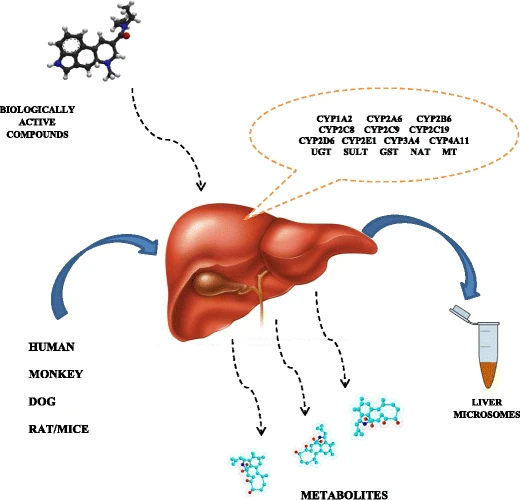

Image is from [this paper](https://link.springer.com/article/10.1007/s00216-016-9929-6). Biologically active compounds can be transformed or destroyed by the action of enzymes in the liver. Microsomes are small membrane bubbles (vesicles) that come from a fragmented cell membrane, and can be used as a proxy for how well a drug survives a trip through the liver.

## Description of readout:
- **PUBCHEM_ACTIVITY_OUTCOME**: Corresponds to the phenotype observed. For all compounds with phenotype "stable", PUBCHEM_ACTIVITY_OUTCOME is "active" (class = 1). For all compounds with phenotype "unstable", PUBCHEM_ACTIVITY_OUTCOME is "inactive" (class = 0).
- **PHENOTYPE**: Based on the half-life observed. Compound is "stable" if half-life (t1/2) is more than 30 minutes (class = 1); "unstable" if t1/2 is less than 30 minutes (class = 0).
- **HALF-LIFE**: Rat liver microsome stability (t1/2), in minutes. >30 minutes has been converted to 31.

**Optimization objective**: Higher stability

## Data resource

**Reference**: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7693334/ 

**Raw data**: https://pubchem.ncbi.nlm.nih.gov/bioassay/1508591

In [12]:
%load_ext autoreload
%autoreload 2

    
import numpy as np
import pandas as pd

import datamol as dm

from polaris import (
    curation,
    load_dataset,
)
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.curation.readouts import detailed_distributions_plots
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner, License
from polaris.hub.client import PolarisHubClient

import tempfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


All datasets were downloaded directly from Pubchem on 2024-03-21 by following the PubChem Bioassay links on https://opendata.ncats.nih.gov/adme/data.

In [2]:
# Load the dataset
aid = 'AID_1508591'
data = pd.read_parquet(f'gs://polaris-public/data/raw/ADME_NCATS/{aid}_raw.parquet')
data

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Half-life (minutes),Analysis Comment,Compound QC
0,RESULT_TYPE,NaN,NaN,None,None,NaN,NaN,NaN,STRING,STRING,STRING,STRING
1,RESULT_DESCR,NaN,NaN,None,None,NaN,NaN,NaN,Indicates type of activity observed: Unstable ...,Rat liver microsome stability (T1/2),Annotation/notes on a particular compound's da...,Source of compound QC
2,1,855633.0,2466.0,CCCCOC1=CC=C(C=C1)CC(=O)NO,Active,NaN,NaN,NaN,stable,>30,class = 0,QC'd by NCATS
3,2,85267104.0,1259573.0,COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC,Active,NaN,NaN,NaN,stable,>30,class = 0,QC'd by NCATS
4,3,7978154.0,1275864.0,COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3...,Active,NaN,NaN,NaN,stable,>30,class = 0,QC'd by NCATS
...,...,...,...,...,...,...,...,...,...,...,...,...
2528,2527,375832297.0,110196975.0,COCCNC(=O)[C@H]1C[C@@H](CN1CC2=CC3=C(C=C2)NC=C...,Inactive,NaN,NaN,NaN,unstable,0.97,class = 1,QC'd by NCATS
2529,2528,375879134.0,45226889.0,CC1=C(C(=CC=C1)N2C3=C(C=N2)C(CCC3)NC(=O)C4=C(C...,Inactive,NaN,NaN,NaN,unstable,0.96,class = 1,QC'd by NCATS
2530,2529,375818434.0,134793165.0,COC(=O)CNC(=O)C1=NC(=C2N1C=CC=C2)C3=CC=C(C=C3)F,Inactive,NaN,NaN,NaN,unstable,0.91,class = 1,QC'd by NCATS
2531,2530,24409378.0,7151268.0,CC1=CSC2=NC(=CN12)C3=CC(=CC=C3)NC(=O)C4=CC=CC=...,Inactive,NaN,NaN,NaN,unstable,0.9,class = 1,QC'd by NCATS


Rows 0 and 1 are metadata; we will keep them separate.

In [3]:
meta_start = 0 # Start row index
meta_end = 2 # End row index + 1
data_meta = data.iloc[meta_start:(meta_end),:].copy() # Save the metadata rows
data = data.drop(labels=list(range(meta_start, meta_end)), axis=0).reset_index(drop=True) # Drop those rows from the main dataframe
data_meta

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Half-life (minutes),Analysis Comment,Compound QC
0,RESULT_TYPE,NaN,NaN,None,None,NaN,NaN,NaN,STRING,STRING,STRING,STRING
1,RESULT_DESCR,NaN,NaN,None,None,NaN,NaN,NaN,Indicates type of activity observed: Unstable ...,Rat liver microsome stability (T1/2),Annotation/notes on a particular compound's da...,Source of compound QC


Drop the metadata rows and keep only the smiles, ID and outcome rows. We'll also turn all columns to uppercase for consistency and rename columns.

In [4]:
# Keep only the SMILES, ID and outcome rows
columns_to_keep = ['PUBCHEM_SID',
                    'PUBCHEM_EXT_DATASOURCE_SMILES', 
                    'PUBCHEM_ACTIVITY_OUTCOME', 
                    'Phenotype',
                    'Half-life (minutes)']
data = data[columns_to_keep]
data.rename(columns = {'PUBCHEM_EXT_DATASOURCE_SMILES' : 'SMILES'}, inplace = True)
# Rename all columns to uppercase
for col in data.columns:
    data.rename(columns={col:col.upper()}, inplace=True)
# Rename half-life (minutes) to half-life (we will specify minutes in the metadata)
data.rename(columns={'HALF-LIFE (MINUTES)': 'HALF-LIFE'}, inplace = True)

In [5]:
data

,PUBCHEM_SID,SMILES,PUBCHEM_ACTIVITY_OUTCOME,PHENOTYPE,HALF-LIFE
0,855633.0,CCCCOC1=CC=C(C=C1)CC(=O)NO,Active,stable,>30
1,85267104.0,COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC,Active,stable,>30
2,7978154.0,COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3...,Active,stable,>30
3,17402368.0,CC(C)(C)N1C2=NC=NC(=C2C(=N1)C3=CC=C(C=C3)Cl)N,Active,stable,>30
4,17511506.0,CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4...,Active,stable,>30
...,...,...,...,...,...
2526,375832297.0,COCCNC(=O)[C@H]1C[C@@H](CN1CC2=CC3=C(C=C2)NC=C...,Inactive,unstable,0.97
2527,375879134.0,CC1=C(C(=CC=C1)N2C3=C(C=N2)C(CCC3)NC(=O)C4=C(C...,Inactive,unstable,0.96
2528,375818434.0,COC(=O)CNC(=O)C1=NC(=C2N1C=CC=C2)C3=CC=C(C=C3)F,Inactive,unstable,0.91
2529,24409378.0,CC1=CSC2=NC(=CN12)C3=CC(=CC=C3)NC(=O)C4=CC=CC=...,Inactive,unstable,0.9


### Map values to digits and replace cutoffs
Half-life is given in minutes but anything over 30 minutes was treated as '>30'. To help with machine readability, we will convert '>30' to 31.0. We will also convert Active/Inactive and Stable/Unstable to binary (1/0 respectively).

In [6]:
# Map active/inactive and stable/unstable to 1 and 0
data['PUBCHEM_ACTIVITY_OUTCOME'] = data['PUBCHEM_ACTIVITY_OUTCOME'].map({'Active':1.0, 'Inactive':0.0})
data['PHENOTYPE'] = data['PHENOTYPE'].map({'stable':1.0, 'unstable':0.0})
# Replace >30 with 31 so it can be operated on
data['HALF-LIFE'].replace('>30', '31.0', inplace = True)
# Convert types after replacement
data['HALF-LIFE'] = data['HALF-LIFE'].astype(float)

In [7]:
# Define data column names
endpoints = [
    'PUBCHEM_ACTIVITY_OUTCOME',
    'PHENOTYPE',
    'HALF-LIFE',
]
data_cols = endpoints
mol_col = 'SMILES'

In [8]:
# data[data_cols[0]] = data[data_cols[0]].astype(int)

In [9]:
from sklearn.utils.multiclass import type_of_target
type_of_target(data[data_cols[0]].dropna().values, input_name=data_cols[0])

'binary'

### Run preliminary curation for data inspection

In [10]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows = True,
)
data_look = curator()

2024-04-05 16:07:56.444 | INFO     | polaris.curation._data_curator:check_outliers:178 - Outlier detection is omit for categorical data PUBCHEM_ACTIVITY_OUTCOME.
2024-04-05 16:07:56.445 | INFO     | polaris.curation._data_curator:check_outliers:178 - Outlier detection is omit for categorical data PHENOTYPE.
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtyp

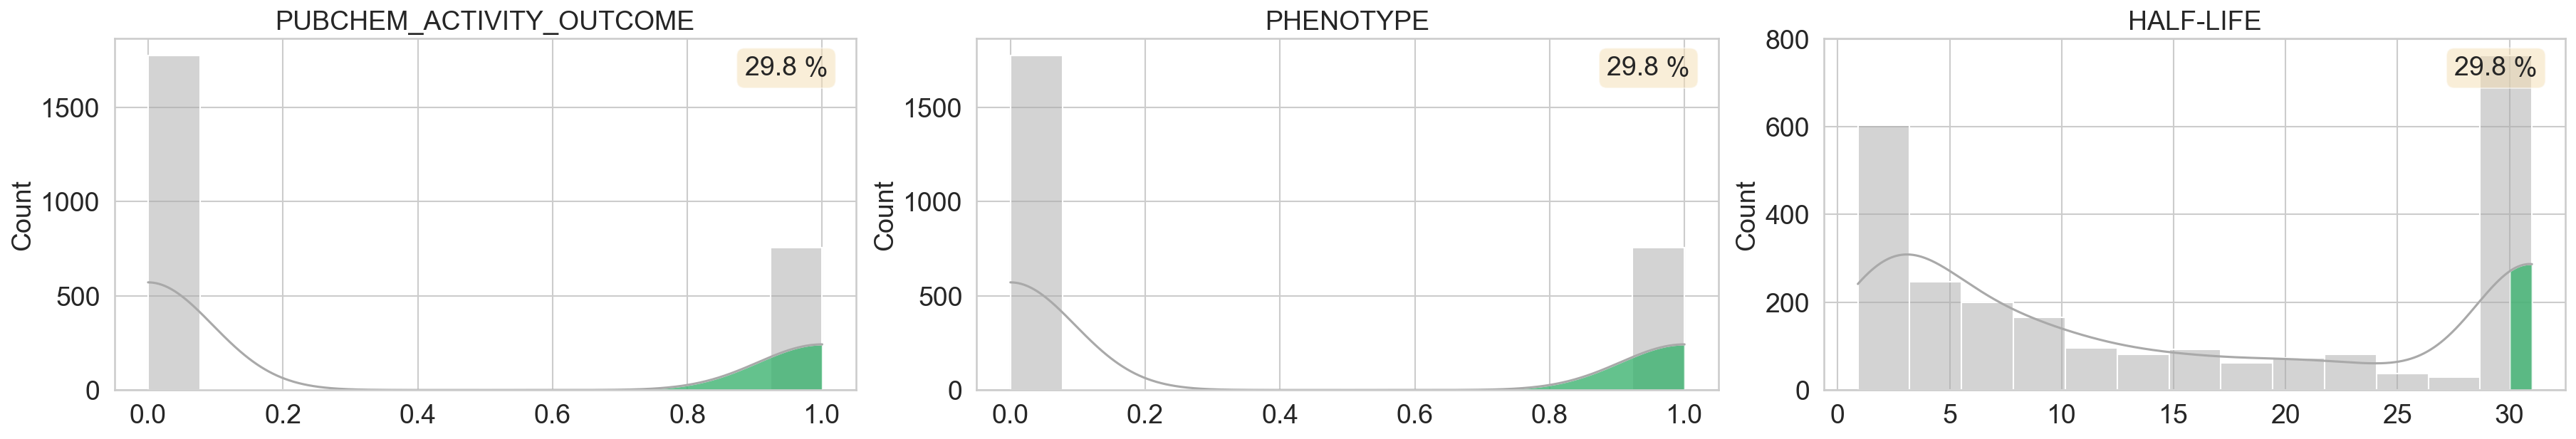

In [13]:
# Distribution plot of all related readouts
fig = detailed_distributions_plots(df=data_look[data_cols], 
                                   thresholds={data_cols[0]: (0.5, np.greater), 
                                               data_cols[1]:(0.5, np.greater), 
                                               data_cols[-1]: (30, np.greater)})

No outliers were detected. Approximately 30% of the data is classified as active, and the rest inactive. This kind of imbalance is closer to a real-world dataset compared to a balanced dataset.

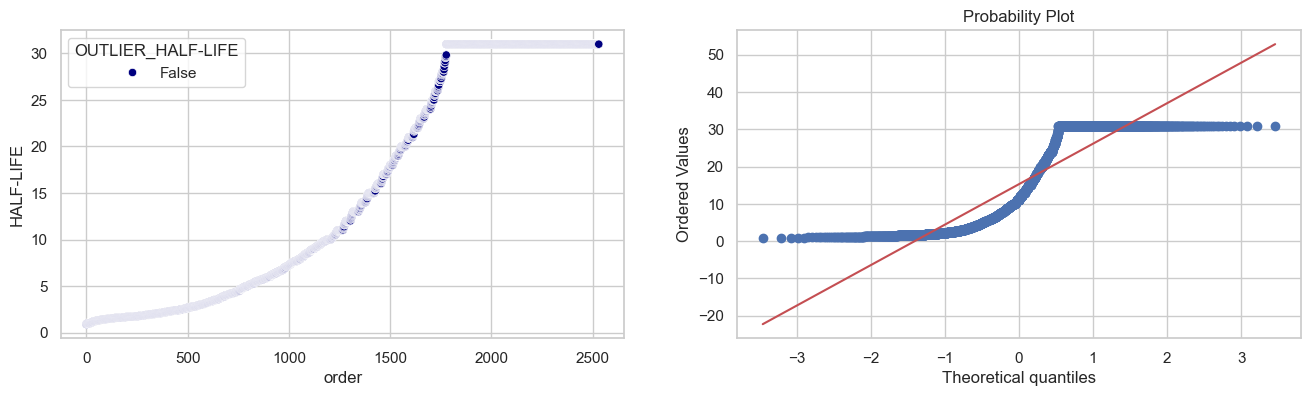

In [14]:
# normality plot only on the continuous data column `HALF-LIFE`
fig = visualize_distribution(dataset=data_look, data_cols=data_cols[-1:])

The readout `HALF-LIFE` is capped by value 31 which limits the usefulness of the normality plot.

### Check activity shift between stereoisomers

In [15]:
data_look[[col for col in data_look.columns if "stereo_cliff" in col]].sum()

PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff    2
PHENOTYPE_stereo_cliff                   2
HALF-LIFE_stereo_cliff                   0
dtype: object

Two possible stereochemistry based activity shifts were detected in the dataset.
Let's check the data in the dataset.

In [16]:
data_look.query("PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff | PHENOTYPE_stereo_cliff")

,PUBCHEM_SID,SMILES,PUBCHEM_ACTIVITY_OUTCOME,PHENOTYPE,HALF-LIFE,ORIGINAL_PUBCHEM_ACTIVITY_OUTCOME,ORIGINAL_PHENOTYPE,ORIGINAL_HALF-LIFE,ORIGINAL_SMILES,smiles,...,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_HALF-LIFE,PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff,PHENOTYPE_stereo_cliff,HALF-LIFE_zscore,HALF-LIFE_stereo_cliff
1851,109967254.0,CN=C1CN=C(C2=C(N1)C=CC(=C2)Cl)C3=CC=CN3,1.0,1.0,26.995,1.0,1.0,31.00,CN=C1CN=C(C2=C(N1)C=CC(=C2)Cl)C3=CC=CN3,CN=C1CN=C(c2ccc[nH]2)c2cc(Cl)ccc2N1,...,0,2,2,False,True,False,True,True,1.182025,NaN
1852,109967257.0,CN=C1CN=C(C2=C(N1)C=CC(=C2)Cl)C3=CC=CN3,0.0,0.0,26.995,0.0,0.0,22.99,CN=C1CN=C(C2=C(N1)C=CC(=C2)Cl)C3=CC=CN3,CN=C1CN=C(c2ccc[nH]2)c2cc(Cl)ccc2N1,...,0,2,2,False,True,False,True,True,1.182025,NaN


As we suspected, two samples with the same smiles but different SIDs are reported as being active or inactive. Looking at the molecules, they seem identical. We can't know which call is correct, so we should **remove** both. We'll do that below, after final curation.

SID 109967254 is [ML223](https://pubchem.ncbi.nlm.nih.gov/substance/109967254) (left). SID 109967257 is [NCGC00188362-03](https://pubchem.ncbi.nlm.nih.gov/substance/109967257) (right) (we've flipped the second molecule across the x axis to get it in the same orientation as the one on the left).

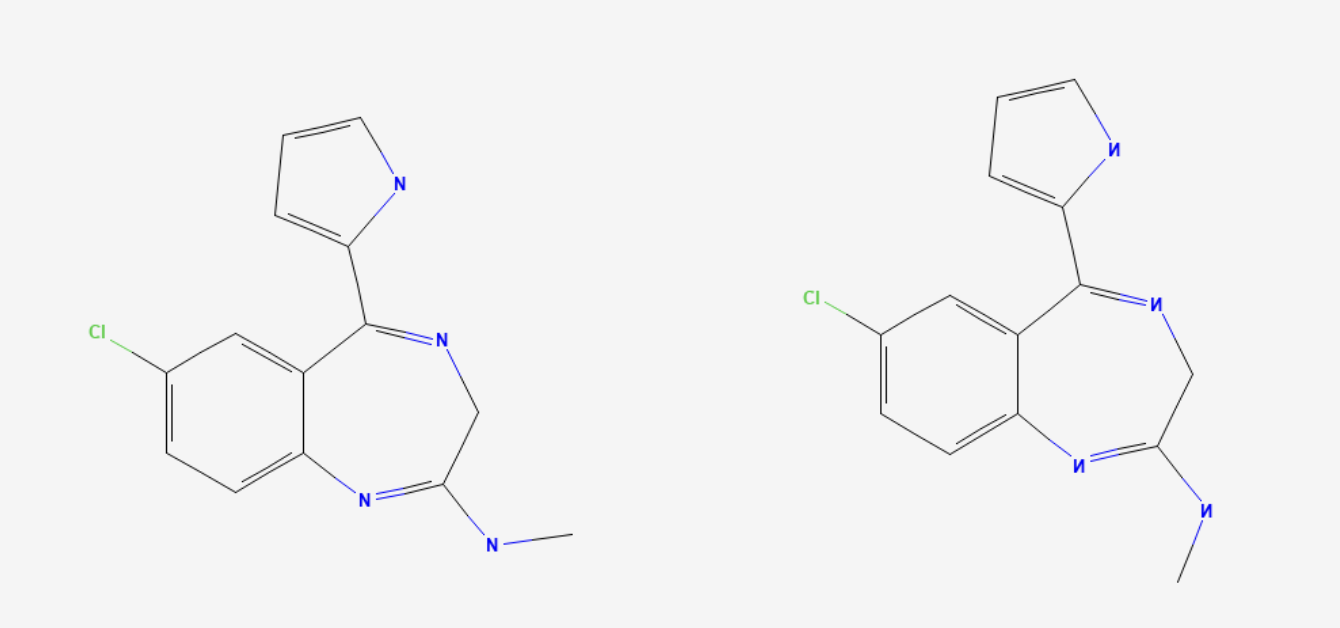

### Removing molecules as needed and re-run curation

In [17]:
# Make a fresh copy of the dataframe without the case where the curator has averaged scores.
data_to_curate = data.query("SMILES != 'CN=C1CN=C(C2=C(N1)C=CC(=C2)Cl)C3=CC=CN3'").reset_index(drop=True)

In [35]:
data_to_curate

,PUBCHEM_SID,SMILES,PUBCHEM_ACTIVITY_OUTCOME,PHENOTYPE,HALF-LIFE
0,855633.0,CCCCOC1=CC=C(C=C1)CC(=O)NO,1.0,1.0,31.00
1,85267104.0,COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC,1.0,1.0,31.00
2,7978154.0,COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3...,1.0,1.0,31.00
3,17402368.0,CC(C)(C)N1C2=NC=NC(=C2C(=N1)C3=CC=C(C=C3)Cl)N,1.0,1.0,31.00
4,17511506.0,CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4...,1.0,1.0,31.00
...,...,...,...,...,...
2524,375832297.0,COCCNC(=O)[C@H]1C[C@@H](CN1CC2=CC3=C(C=C2)NC=C...,0.0,0.0,0.97
2525,375879134.0,CC1=C(C(=CC=C1)N2C3=C(C=N2)C(CCC3)NC(=O)C4=C(C...,0.0,0.0,0.96
2526,375818434.0,COC(=O)CNC(=O)C1=NC(=C2N1C=CC=C2)C3=CC=C(C=C3)F,0.0,0.0,0.91
2527,24409378.0,CC1=CSC2=NC(=CN12)C3=CC(=CC=C3)NC(=O)C4=CC=CC=...,0.0,0.0,0.90


In [36]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data_to_curate,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules that have undefined stereocenters and also show activity shift to the stereoisomers
    mask_stereo_undefined_mols=True,
    # remove all the molecule rows including the duplicates
    keep_all_rows=False,
)
data_curated = curator_with_stereo()

2024-04-05 16:14:23.299 | INFO     | polaris.curation._data_curator:check_outliers:178 - Outlier detection is omit for categorical data PUBCHEM_ACTIVITY_OUTCOME.
2024-04-05 16:14:23.300 | INFO     | polaris.curation._data_curator:check_outliers:178 - Outlier detection is omit for categorical data PHENOTYPE.
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtyp

In [37]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(description="Molecule SMILES string", modality="molecule"),

    'PUBCHEM_ACTIVITY_OUTCOME': ColumnAnnotation(description="Binarized label based on the phenotype observed, active (class = 1) or inactive (class = 0)",
                                user_attributes={"ref_col": 'PHENOTYPE'}),

    'PHENOTYPE': ColumnAnnotation(description='Indicates type of activity observed: Unstable (<30 min) (class = 0), Stable (>30 min) (class = 1).',
                    user_attributes={"ref_col": 'HALF-LIFE'}), 

    'HALF-LIFE': ColumnAnnotation(description= 'Rat liver microsome stability (T1/2)', # We can use the metadata we collected previously
            user_attributes={"unit": "minutes"}),
}

In [44]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated[['smiles', 'PUBCHEM_ACTIVITY_OUTCOME', 'PHENOTYPE', 'HALF-LIFE']].copy(),
    # Additional meta-data on the dataset level.
    name="ADME_NCATS_RLM_Stability",
    description="ADME RLM Stability experiment data released by the National Center for Advancing Translational Sciences",
    source="https://doi.org/10.1038/s41598-020-77327-0",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Shawn Whitfield", slug="swhitfield"),
    license=License(id="CC-BY-4.0"),
    user_attributes={"year": "2020"},
)

In [39]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

/Users/lu.zhu/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


['/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmpbqoqf0dn/dataset/table.parquet',
 '/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmpbqoqf0dn/dataset/dataset.json']

In [40]:
# data_curated.to_parquet(f'./data/{aid}_curated.parquet') # Save just in case. Requires a data folder.

In [41]:
# Load dataset through json file given
# dataset = load_dataset(path)

In [42]:
# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)